In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os


Dataset Overview:
              source    mean_x    mean_y    mean_z      std_x     std_y  \
0  acc_walking_waist  2.663950 -0.351415  0.061519  10.083317  2.034828   
1  acc_walking_waist  1.196071 -0.226222 -0.213210  10.273308  1.865000   
2  acc_walking_waist  2.692417 -0.126552 -0.077440   9.847344  2.057656   
3  acc_walking_waist  4.010665  0.520452 -0.575668   9.115871  2.160928   
4  acc_walking_waist  2.825762 -0.567246  0.095978  10.245888  2.174290   

      std_z    skew_x    skew_y    skew_z    kurt_x    kurt_y    kurt_z  \
0  3.061457 -0.323016 -1.014452  0.189741 -1.507876  1.262191 -0.078977   
1  3.089884 -0.161147 -0.822792 -0.065526 -1.608798  3.464301  0.222478   
2  2.821098 -0.401679  0.118501  0.336297 -1.470244  1.424952 -0.193981   
3  2.821521 -0.654599  0.133201 -0.246515 -1.086870  1.193961 -0.454845   
4  3.136748 -0.393514 -1.028048 -0.328757 -1.481341  3.493386 -0.102635   

   magnitude_mean  magnitude_std  zero_crossings_x  zero_crossings_y  \
0       

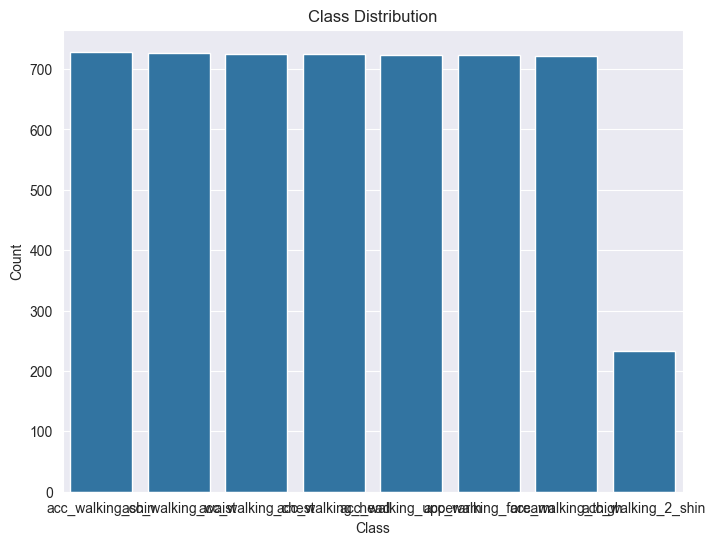

In [8]:
# Load feature data
feature_file = "../data/processed/feature_data.csv"
data = pd.read_csv(feature_file)

# Display dataset information
print("Dataset Overview:")
print(data.head())
print("\nDataset Shape:", data.shape)
print("\nClass Distribution:")
print(data['source'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='source', order=data['source'].value_counts().index)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [9]:
# Prepare features and labels
X = data.drop(columns=["source"])
y = data["source"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)



Training Set Shape: (4245, 17)
Test Set Shape: (1062, 17)


In [10]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of trees
    'max_depth': [None, 10, 20, 30],          # Maximum depth of trees
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required to be a leaf node
    'max_features': ['sqrt', 'log2', None]    # Number of features to consider at every split
}

# Perform grid search
print("Performing Hyperparameter Tuning...")
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)


Performing Hyperparameter Tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}



Classification Report:
                      precision    recall  f1-score   support

  acc_walking_2_shin       1.00      0.98      0.99        49
   acc_walking_chest       1.00      1.00      1.00       141
 acc_walking_forearm       1.00      1.00      1.00       144
    acc_walking_head       1.00      1.00      1.00       135
    acc_walking_shin       0.99      1.00      1.00       141
   acc_walking_thigh       1.00      1.00      1.00       144
acc_walking_upperarm       1.00      1.00      1.00       148
   acc_walking_waist       1.00      1.00      1.00       160

            accuracy                           1.00      1062
           macro avg       1.00      1.00      1.00      1062
        weighted avg       1.00      1.00      1.00      1062



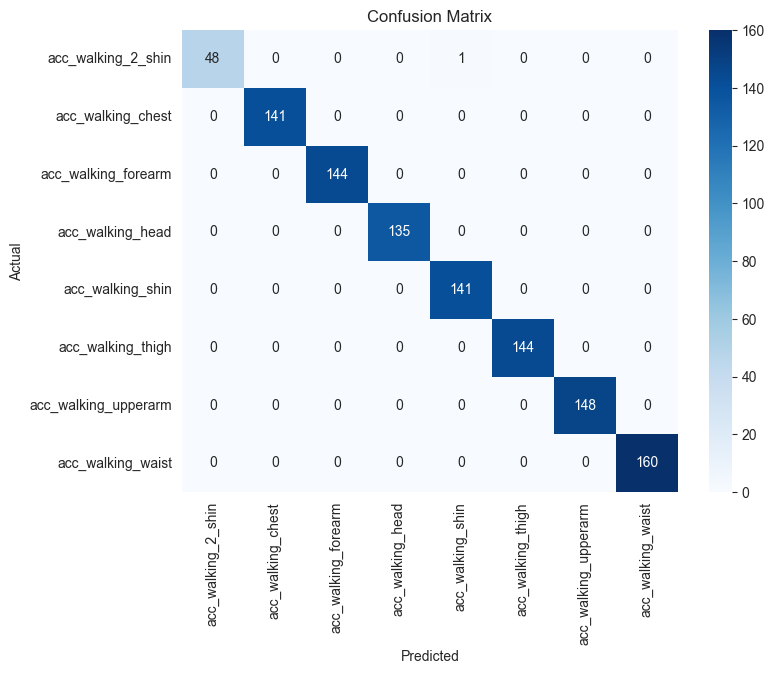

In [11]:
# Evaluate the model
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


C:\Users\saif\AppData\Local\Temp\ipykernel_23164\2675469095.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_indices], y=sorted_features, palette='viridis')


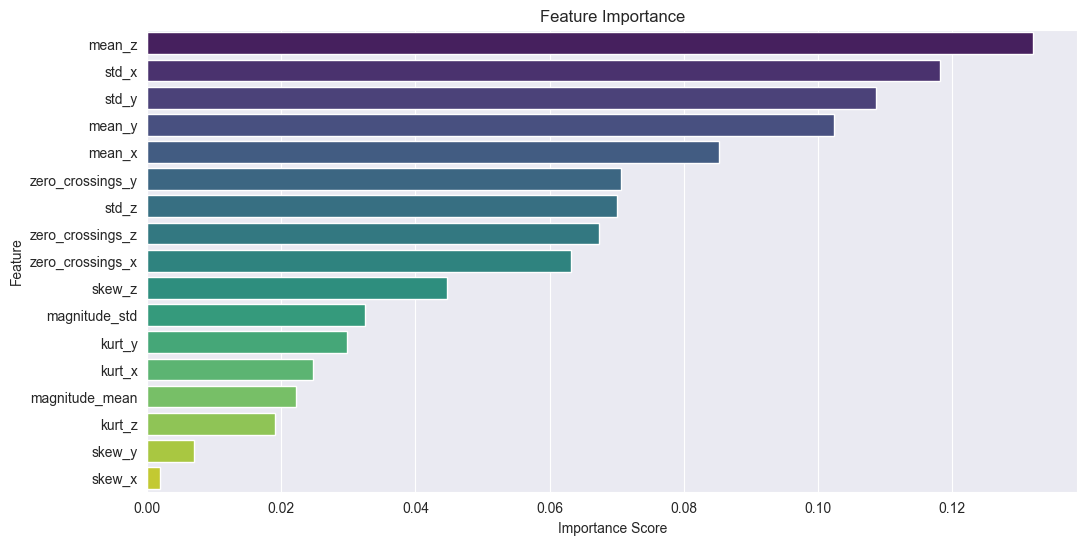

In [12]:
# Visualize feature importance
feature_importances = best_model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances[sorted_indices], y=sorted_features, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [13]:
def save_model(model, model_dir, model_name="random_forest_model.pkl"):
    """
    Save the trained model to a specified directory.

    Args:
        model: Trained model to save.
        model_dir (str): Directory to save the model.
        model_name (str): Name of the saved model file.
    """
    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    model_path = os.path.join(model_dir, model_name)
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

# Save the model
save_model(best_model, "../models/")


Model saved to ../models/random_forest_model.pkl
